In [1]:
!rm -r ./Datasets/train
!rm -r ./Datasets/test
!rm -r ./saved_models/new_model

rm: ./Datasets/train: No such file or directory
rm: ./Datasets/test: No such file or directory


In [2]:
import torch
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from time import time
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder, Food101
from torch.utils.data import DataLoader
from torch import nn
from scripts import utilities, dataset_setup, model_setup


# VARIABLES NEEDED TO RUN THE TRAINING - GENERAL SETTINGS FOR THE TRAINING

In [3]:
#the default folder to save new models and the log
MODEL_FOLDER = pathlib.Path(os.getcwd() + '/saved_models/new_model')
LOG_FOLDER = MODEL_FOLDER
FOOD101_PATH = pathlib.Path(os.getcwd() + '/Datasets/food-101') #folder where the original dataset is stored in the  
DATASET_TRAIN_FOLDER = pathlib.Path(os.getcwd() + '/Datasets/train')
DATASET_TEST_FOLDER = pathlib.Path(os.getcwd() + '/Datasets/test')

NUMBER_OF_CLASSES = 5 #number of classes to use for the training
RESIZE = (224, 224)
BATCH_SIZE = 2 ** 5
LEARNING_RATE = 5e-3
#setting up a logger Agent
logger = utilities.Logging_Agent(LOG_FOLDER)


In [4]:
torch.__version__

'2.6.0'

In [5]:
os.chdir('/Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/05_PyTorch_Food101')
os.getcwd()

'/Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/05_PyTorch_Food101'

In [6]:
#set your own token and chat_id here if you need telegram messages to be sent to track the execution of your program.    
#use a specific file *.env for the case and store it in a given path

dot_env_path='/Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/05_PyTorch_Food101/TelegramLogIn.env'

from dotenv import load_dotenv
load_dotenv(dot_env_path) 

True

FOOD101_PATH = pathlib.Path(os.getcwd() + '/Datasets')
print(FOOD101_PATH)

if not FOOD101_PATH.exists():
    os.makedirs(FOOD101_PATH)
    Food101(root=FOOD101_PATH, download=True)
    logger.write_log(f'The Food101 dataset has been downloaded and is available @ {FOOD101_PATH}')
else:
    logger.write_log(f'The Food101 dataset already exists @ {FOOD101_PATH}')

### First of all let's check whether the dataset has been already downloaded. If not, let's download it from the Torchvision library

In [7]:
train_test_foods = dataset_setup.dataset_creation(
    food101_folder=FOOD101_PATH,
    dataset_train_folder=DATASET_TRAIN_FOLDER,
    dataset_test_folder=DATASET_TEST_FOLDER,
    logger=logger,
    nr_classes=5,
    picked_foods=['french_fries', 'cup_cakes', 'sushi', 'steak', 'pizza']
)

Creating dataset train and test folders:
The folders have been created:
	/Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/05_PyTorch_Food101/Datasets/train
	/Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/05_PyTorch_Food101/Datasets/test
The picked food french_fries has 1000 samples.
Copied 800 files to /Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/05_PyTorch_Food101/Datasets/train/french_fries
Copied 200 files to /Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/05_PyTorch_Food101/Datasets/test/french_fries
The picked food cup_cakes has 1000 samples.
Copied 800 files to /Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/05_PyTorch_Food101/Datasets/train/cup_cakes
Copied 200 files to /Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/05_PyTorch_Food101/Datasets/test/cup_cakes
The picked food sushi has 1000 samples.
Copied 800 files to /Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/05_PyTorch_Food101/Datasets/train/sushi
Copied 200 files to /Us

### Giving a look at 9 random pictures just copied into the train and test folders

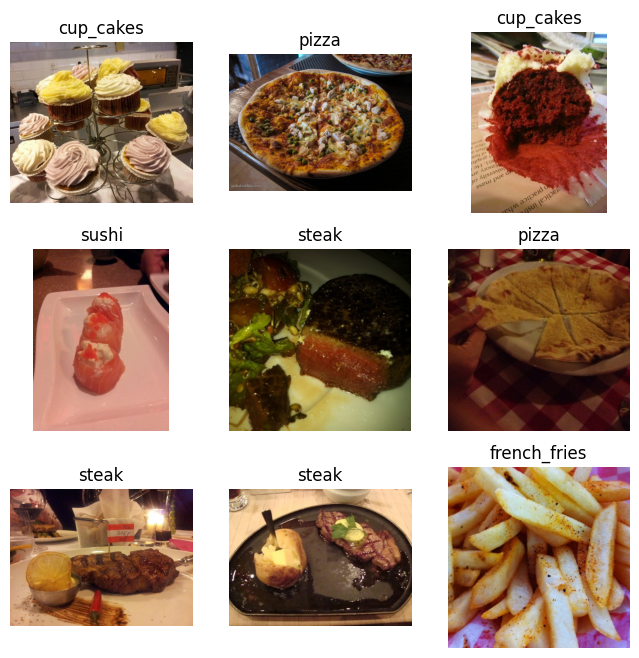

In [8]:
utilities.plot_samples(
    path=DATASET_TRAIN_FOLDER,
    classes_names=train_test_foods,
)

### Let's create a transform function to import the data stored in the folders created and have some data augmentation in the meantime

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


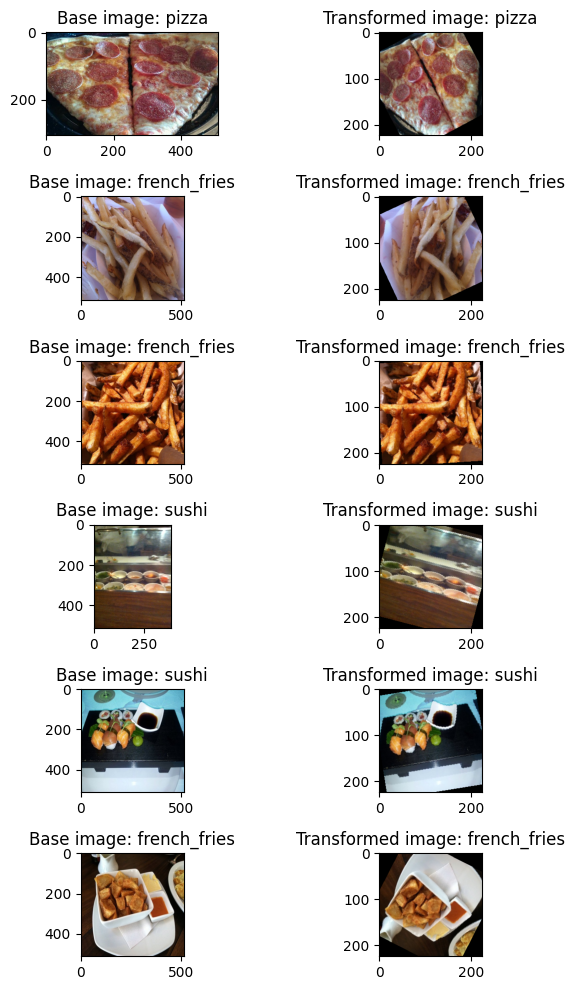

In [9]:
transform = nn.Sequential(
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(RESIZE),
    v2.RandomHorizontalFlip(p=0.25),
    v2.RandomVerticalFlip(p=0.25),
    v2.RandomRotation(degrees=30),
    v2.RandomPerspective(p=0.25, distortion_scale=0.2),
)

transform_test = nn.Sequential(
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(RESIZE),
)

utilities.plot_samples_transformed(
    path=DATASET_TRAIN_FOLDER,
    transform=transform,
    classes_names=train_test_foods,
)

### We create the datasets starting from the folders created and check whether the classes are properly generated

In [10]:
train_dataset = ImageFolder(root=DATASET_TRAIN_FOLDER, transform=transform)
test_dataset = ImageFolder(root=DATASET_TEST_FOLDER, transform=transform_test)
logger.write_log(f'The datasets have been created...\n\tThe train dataset has {len(train_dataset):_} images\n\tThe test dataset has {len(test_dataset):_} images')

The datasets have been created...
	The train dataset has 4_000 images
	The test dataset has 1_000 images


In [11]:
train_dataset,test_dataset

(Dataset ImageFolder
     Number of datapoints: 4000
     Root location: /Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/05_PyTorch_Food101/Datasets/train
     StandardTransform
 Transform: Sequential(
              (0): ToImage()
              (1): ToDtype(scale=True)
              (2): Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
              (3): RandomHorizontalFlip(p=0.25)
              (4): RandomVerticalFlip(p=0.25)
              (5): RandomRotation(degrees=[-30.0, 30.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
              (6): RandomPerspective(p=0.25, distortion_scale=0.2, interpolation=InterpolationMode.BILINEAR, fill=0)
            ),
 Dataset ImageFolder
     Number of datapoints: 1000
     Root location: /Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/05_PyTorch_Food101/Datasets/test
     StandardTransform
 Transform: Sequential(
              (0): ToImage()
              (1): ToDtype(scale=True)


In [12]:
logger.write_log(f'The classes of the datasets are mapped like so: \n\t{train_dataset.class_to_idx}')

The classes of the datasets are mapped like so: 
	{'cup_cakes': 0, 'french_fries': 1, 'pizza': 2, 'steak': 3, 'sushi': 4}


### Finally we create a DataLoader

In [13]:
train_batches = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
logger.write_log(f'The dataloaders are on, with batch size {BATCH_SIZE}')
logger.write_log(f'Number of batches (training): {len(train_batches)}')

The dataloaders are on, with batch size 32
Number of batches (training): 125


### MPS agnostic code setting

In [14]:
device = 'mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
logger.write_log(f'Using {device} device')

Using mps device


### Creating a model0 class and instantiating it...

In [15]:
model0 = model_setup.TinyVGG(
    name='TinyVGG',
    input_size=3,
    first_hidden_channels=10,
    second_hidden_channels=15,
    first_hidden_linear_nodes=15 * 56 * 56,
    output_size=NUMBER_OF_CLASSES,
)

In [16]:
from torchinfo import summary

model_info = summary(model0, input_size=[16, 3, 224, 224])

with open(MODEL_FOLDER / 'model_info.txt', 'w') as f:
    f.write(str(model_info))

model_info

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [16, 5]                   --
├─Sequential: 1-1                        [16, 10, 112, 112]        --
│    └─Conv2d: 2-1                       [16, 10, 224, 224]        280
│    └─ReLU: 2-2                         [16, 10, 224, 224]        --
│    └─MaxPool2d: 2-3                    [16, 10, 112, 112]        --
├─Sequential: 1-2                        [16, 15, 56, 56]          --
│    └─Conv2d: 2-4                       [16, 15, 112, 112]        1,365
│    └─ReLU: 2-5                         [16, 15, 112, 112]        --
│    └─MaxPool2d: 2-6                    [16, 15, 56, 56]          --
├─Sequential: 1-3                        [16, 5]                   --
│    └─Flatten: 2-7                      [16, 47040]               --
│    └─Linear: 2-8                       [16, 5]                   235,205
Total params: 236,850
Trainable params: 236,850
Non-trainable params: 0
Tota

In [17]:
model0.to(device=device)
logger.write_log(f'The model is created and loaded on: {next(model0.parameters()).device}')

The model is created and loaded on: mps:0


In [18]:
#testing the model functionality with the first picture in the dataloader. Just to see whether the outcome is consistent with what we expect or not:
test_pic = next(iter(train_batches))[0][0].unsqueeze(dim=0).to(device=device)
model0.eval()
with torch.no_grad():
    outcome_test = model0(test_pic)

logger.write_log(f'The outcome of the tast performed on the first picture fetched from the dataloader is: '
      f'\n\tLOGITS: {outcome_test}'
      f'\n\tPROBABILITIES: {torch.softmax(outcome_test, dim=1)}'
      f'\n\tPREDICTED CLASS: {torch.argmax(torch.softmax(outcome_test, dim=1), dim=1).item()}')

The outcome of the tast performed on the first picture fetched from the dataloader is: 
	LOGITS: tensor([[-0.0319,  0.0399, -0.0197,  0.0157, -0.0104]], device='mps:0')
	PROBABILITIES: tensor([[0.1939, 0.2083, 0.1963, 0.2034, 0.1981]], device='mps:0')
	PREDICTED CLASS: 1



### We set an optimizer and a loss function with the latter being a CrossEntropyLossFunction from torch.nn (<a href='https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss'>link</a>)

In [19]:
ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model0.parameters(), lr=LEARNING_RATE)

logger.write_log(f'The Learning Rate is set to {LEARNING_RATE} | Optimizer is on and ready...')

The Learning Rate is set to 0.005 | Optimizer is on and ready...


In [20]:
from tqdm.auto import tqdm
epochs = 0
end_epochs = 150

utilities.send_telegram('Training started...')

start_time = time()
for epoch in range(epochs, end_epochs):
    logger.write_log(f'EPOCH NUMBER: {epoch + 1} out of {end_epochs}')
    train_loss = []
    cv_loss = []
    train_acc = []
    cv_acc = []
    start_time_epoch = time() #marking the starting time for the epoch training
    for batch_index, (batch_X, batch_y) in enumerate(train_batches):
        
        start_time_batch = time()
        
        #training step per every batch. the function returns the loss and accuracy
        model0.train() #switches on the train mode from torch module
        loss_batch, acc_batch = model0.train_step(batch_X=batch_X, 
                                                  batch_y=batch_y,
                                                  optimizer=optimizer, 
                                                  loss_foo=ce_loss,
                                                  device=device)

        #appending the losses computed for the batch to the container for the whole epoch
        train_loss.append(loss_batch)
        train_acc.append(acc_batch)
        
        end_time_batch = time()
        
        if batch_index % 50 == 0:
            resume_batch = model0.write_minibatch_results_class(
                batch_index=batch_index,
                batch_quantity=len(train_batches),
                train_loss=train_loss,
                batch_loss_train=loss_batch,
                train_acc=train_acc,
                batch_acc_train=acc_batch,
                start_time_iteration=start_time_batch,
                end_time_iteration=end_time_batch
            )
            logger.write_log(resume_batch)
            
    #5. CrossValidation step (once per epoch...)
    model0.eval()
    for batch_test_X, batch_test_y in test_batches:
        loss_batch_cv, acc_batch_cv = model0.eval_step(
            batch_test_X=batch_test_X,
            batch_test_y=batch_test_y,
            loss_foo=ce_loss,
            device=device
        )
            
        #appending the losses computed for the batch to the container for the whole epoch
        cv_loss.append(loss_batch_cv)
        cv_acc.append(acc_batch_cv)
        
    #marking the end time for the epoch training
    end_time_epoch = time()
    epoch_resume = model0.write_epoch_results_class(
        curr_iteration=epoch,
        last_iteration=end_epochs,
        train_loss=train_loss,
        train_acc=train_acc,
        cv_loss=cv_loss,
        cv_acc=cv_acc,
        end_time_iteration=end_time_epoch,
        start_time_iteration=start_time_epoch
    )
    logger.write_log(epoch_resume)
    utilities.send_telegram(epoch_resume)

    #keep track of the history of the training metrics
    model0.history_update('train_loss', np.mean(train_loss).item())
    model0.history_update('train_acc', np.mean(train_acc).item())
    model0.history_update('cv_loss', np.mean(cv_loss).item())
    model0.history_update('cv_acc', np.mean(cv_acc).item())
    
    if epoch % 20 == 0 & epoch != 0:
        utilities.save_model(
            path=MODEL_FOLDER,
            model=model0,
            optimizer=optimizer,
            epoch_nr=end_epochs,
            learning_rate=LEARNING_RATE,
            batch_size=BATCH_SIZE,
            nr_classes=NUMBER_OF_CLASSES
        )
        logger.write_log(f'Model and optimizer saved for the checkpoint @epoch nr.: {epoch}')

end_time = time()
utilities.send_telegram('Training closed succesfully...')

EPOCH NUMBER: 1 out of 150
Intermediate results for batch 000 out of 125: Train Loss epoch:    1.605 (last:    1.605) | Train Acc. epoch: 28.12% (last: 28.12%) | Elapsed Time: 1.0 sec.
Intermediate results for batch 050 out of 125: Train Loss epoch:    1.608 (last:    1.609) | Train Acc. epoch: 21.81% (last: 18.75%) | Elapsed Time: 0.0 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    1.604 (last:    1.573) | Train Acc. epoch: 22.59% (last: 28.12%) | Elapsed Time: 0.0 sec.
Epoch number: 1 out of 150
	Train loss: 1.601 | Train Accuracy: 23.450%
	CV loss:    1.594 | CV Accuracy:    19.824%
	Time taken: 14.67 seconds
EPOCH NUMBER: 2 out of 150
Intermediate results for batch 000 out of 125: Train Loss epoch:    1.584 (last:    1.584) | Train Acc. epoch: 12.50% (last: 12.50%) | Elapsed Time: 0.0 sec.
Intermediate results for batch 050 out of 125: Train Loss epoch:    1.570 (last:    1.569) | Train Acc. epoch: 29.23% (last: 25.00%) | Elapsed Time: 0.0 sec.
Intermediate

In [21]:
utilities.save_model(
    path=MODEL_FOLDER,
    model=model0,
    optimizer=optimizer,
    epoch_nr=end_epochs,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    nr_classes=NUMBER_OF_CLASSES
)

Model metrics history saved in :
	/Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/05_PyTorch_Food101/saved_models/new_model


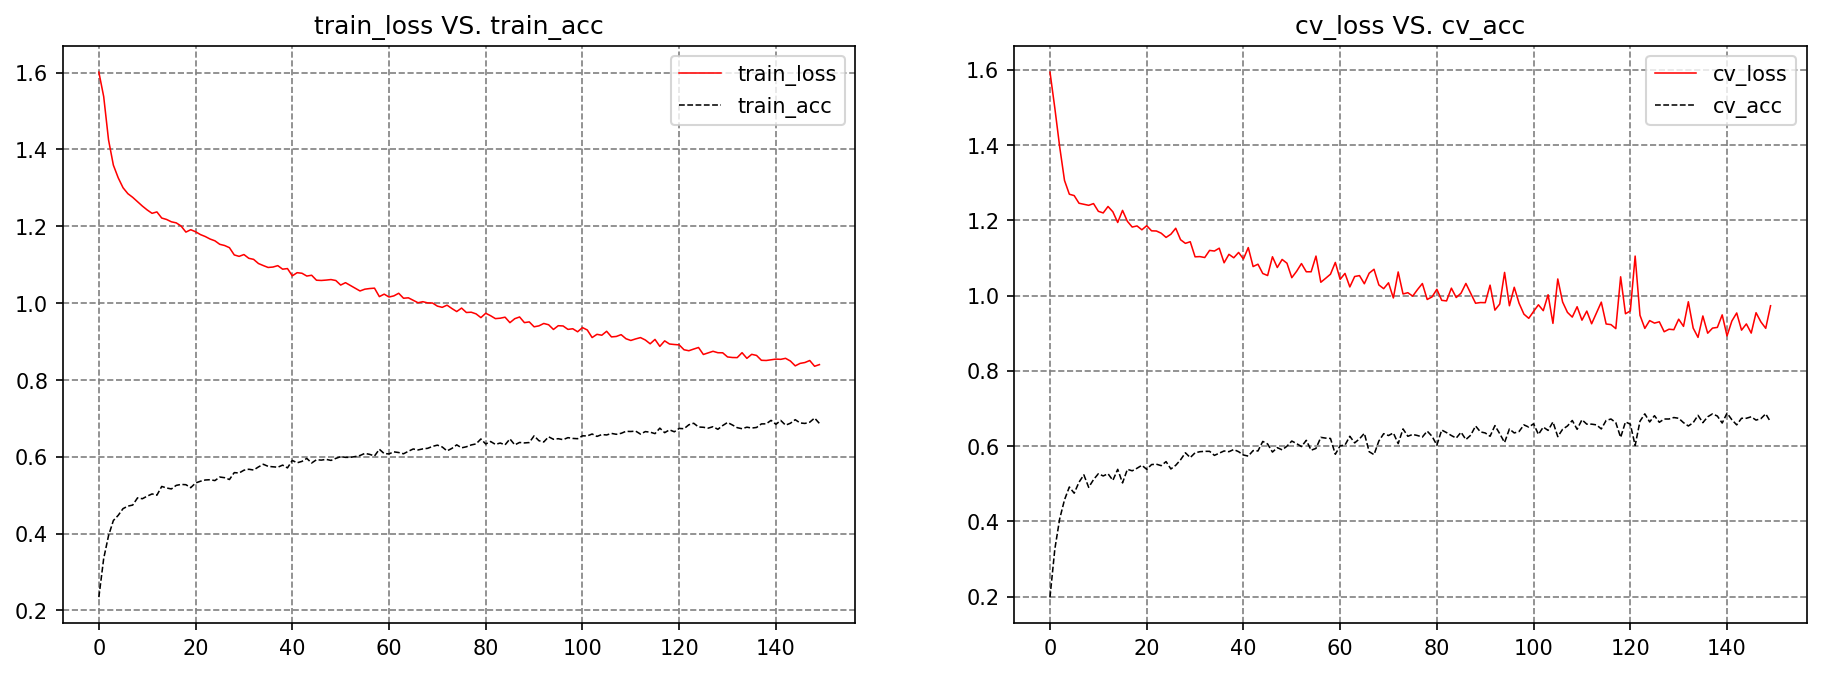

In [22]:
import matplotlib.pyplot as plt
metrics = [('train_loss', 'train_acc'),
           ('cv_loss', 'cv_acc')]

fig = plt.figure(figsize=[15, 5], dpi=150)
for index, (loss, acc) in enumerate(metrics):
    fig.add_subplot(1, 2, index + 1)
    plt.plot(
        np.arange(len(model0.history[loss])),
        model0.history[loss],
        label=loss,
        color='red',
        linewidth = 0.75,
    )
    plt.plot(
        np.arange(len(model0.history[loss])),
        model0.history[acc],
        label = acc,
        color='black',
        linewidth = 0.75,
        linestyle='--'
    )
    plt.legend()
    plt.title(f'{loss } VS. {acc}')


    plt.grid(linestyle='--', color='gray')

plt.savefig(MODEL_FOLDER / 'loss_acc_history.jpg')


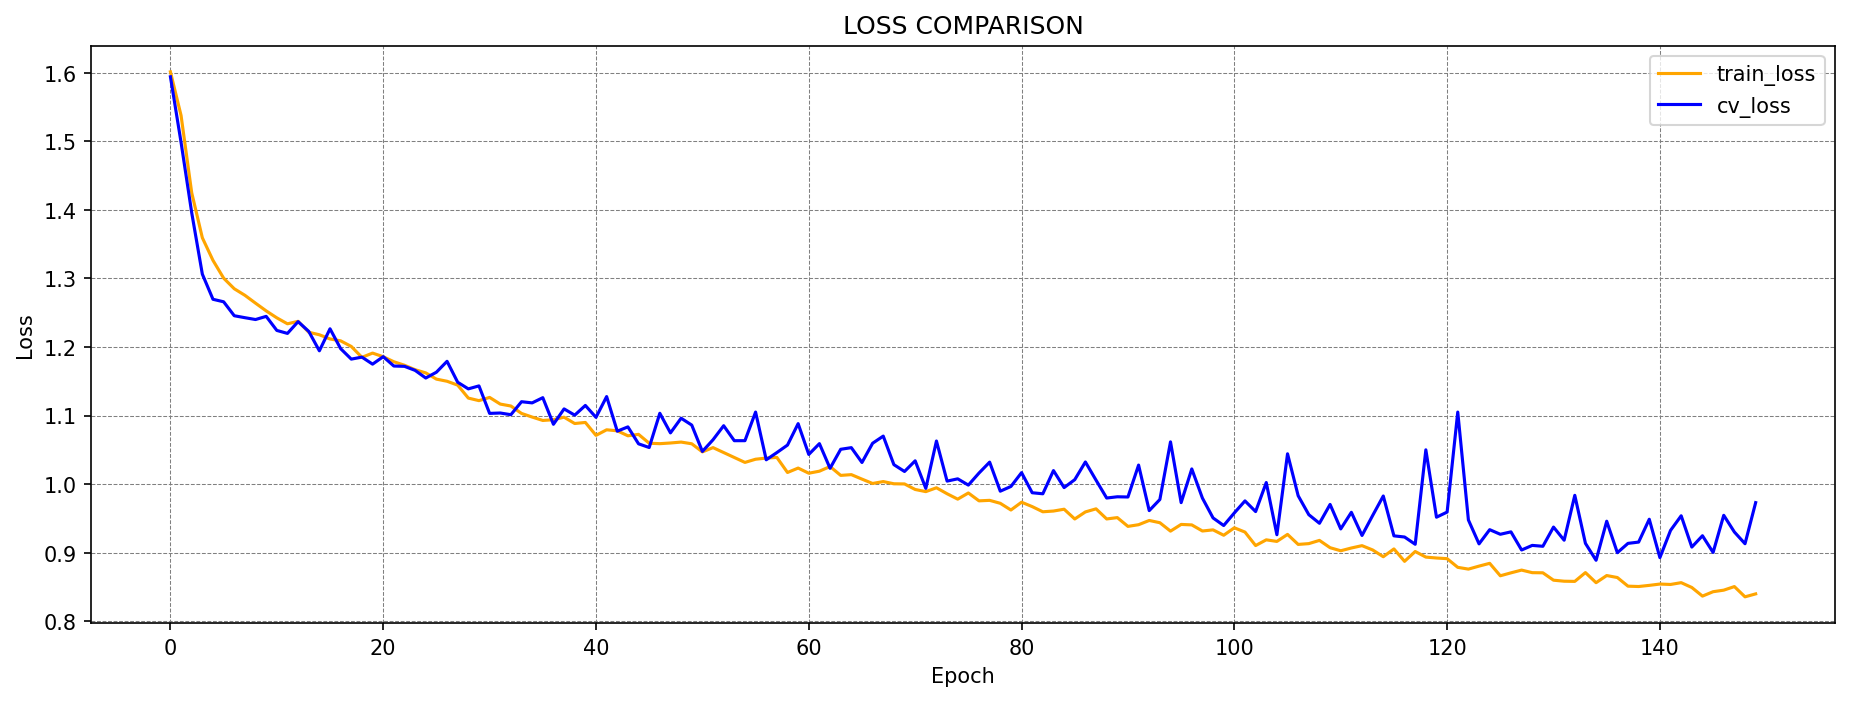

In [23]:
fig = plt.figure(figsize=[15, 5], dpi=150)
plt.plot(np.arange(len(model0.history[loss])), model0.history['train_loss'], color='orange', label='train_loss')
plt.plot(np.arange(len(model0.history[loss])), model0.history['cv_loss'], color='blue', label='cv_loss')
plt.title('LOSS COMPARISON')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(linewidth='.5', linestyle='--', color='gray')
plt.savefig(MODEL_FOLDER / 'loss_comparison.jpg')

In [24]:
model0.to(device='mps')
model0.compute_outcome(train_batches, test_batches, ce_loss)

TypeError: to() received an invalid combination of arguments - got (device=CrossEntropyLoss, ), but expected one of:
 * (torch.device device = None, torch.dtype dtype = None, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)
 * (torch.dtype dtype, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)
 * (Tensor tensor, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)


In [25]:
train_dataset.class_to_idx

{'cup_cakes': 0, 'french_fries': 1, 'pizza': 2, 'steak': 3, 'sushi': 4}